# Clasificador de Fraude en Canastas de Compra

Este notebook implementa un clasificador binario para detectar fraude en canastas de compra utilizando Regresión Logística.

**Problema**: Predecir si una canasta de compra es fraudulenta basándose en los artículos comprados y características agregadas.

**Dataset**: 9,318 canastas con 2,474 productos + 6 características agregadas (99.93% sparse)

**Modelo principal**: Regresión Logística con regularización Lasso (L1) - ideal para datos dispersos y selección automática de características

# 1. Bibliotecas y Funciones

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    roc_curve, 
    auc,
    RocCurveDisplay
)

import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [39]:
def evaluacion_modelo(modelo, X_train, y_train, X_test, y_test, nombre_modelo='Modelo'):
    """
    Evalúa el modelo en conjuntos de entrenamiento y prueba.
    Muestra matrices de confusión lado a lado.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Evaluación en entrenamiento
    y_train_pred = modelo.predict(X_train)
    acc_train = accuracy_score(y_train, y_train_pred) * 100
    
    cm_train = pd.crosstab(
        y_train, 
        y_train_pred,
        rownames=['Real'],
        colnames=['Predicción']
    )
    sns.heatmap(cm_train, annot=True, fmt='g', ax=ax1, cmap='Blues')
    ax1.set_title(f'{nombre_modelo} - Entrenamiento\nAccuracy: {acc_train:.2f}%')
    
    # Evaluación en prueba
    y_test_pred = modelo.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred) * 100
    
    cm_test = pd.crosstab(
        y_test,
        y_test_pred,
        rownames=['Real'],
        colnames=['Predicción']
    )
    sns.heatmap(cm_test, annot=True, fmt='g', ax=ax2, cmap='Blues')
    ax2.set_title(f'{nombre_modelo} - Prueba\nAccuracy: {acc_test:.2f}%')
    
    plt.tight_layout()
    plt.show()
    
    # Reporte de clasificación
    print(f"\n{'='*60}")
    print(f"Reporte de Clasificación - {nombre_modelo} (Conjunto de Prueba)")
    print(f"{'='*60}")
    print(classification_report(y_test, y_test_pred, target_names=['No Fraude', 'Fraude']))
    
    return acc_train, acc_test

In [40]:
def matriz_confusion_con_umbral(modelo, X_test, y_test, umbral=0.5):
    """
    Crea matriz de confusión usando un umbral personalizado.
    """
    y_pred_proba = modelo.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > umbral).astype(int)
    
    cm = pd.crosstab(
        y_test,
        y_pred,
        rownames=['Real'],
        colnames=['Predicción']
    )
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Matriz de Confusión (umbral={umbral})')
    plt.show()
    
    acc = accuracy_score(y_test, y_pred) * 100
    print(f"\nAccuracy con umbral {umbral}: {acc:.2f}%")
    print(f"\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=['No Fraude', 'Fraude']))

# 2. Lectura y Exploración Inicial de Datos

In [41]:
# Cargar datos
df = pd.read_csv('https://raw.githubusercontent.com/andrestrevino-EpsilonTech/Examen_reto1_clasificador_canastas_fraude/refs/heads/main/Datos/FraudeCanastas.csv')

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nPrimeras filas:")
df.head()

Dimensiones del dataset: (9319, 2457)

Primeras filas:


,ID,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
0,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1299,649.500000,1299,0.0,1.0
1,195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3,3,4119,1373.000000,2470,0.0,1.0
2,217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,2806,1403.000000,2799,7.0,1.0
3,552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1206,603.000000,1199,7.0,1.0
4,854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,19,27,1807,66.925926,195,4.0,1.0


In [42]:
# Información general
print("Información del dataset:")
print(f"Total de registros: {len(df)}")
print(f"Total de columnas: {df.shape[1]}")
print(f"\nValores nulos por columna:")
print(df.isnull().sum().sum())  # Total de nulos

Información del dataset:
Total de registros: 9319
Total de columnas: 2457

Valores nulos por columna:
0


Distribución de la variable objetivo (fraud_flag):
fraud_flag
0.0    8000
1.0    1319
Name: count, dtype: int64

Proporción:
fraud_flag
0.0    0.858461
1.0    0.141539
Name: proportion, dtype: float64


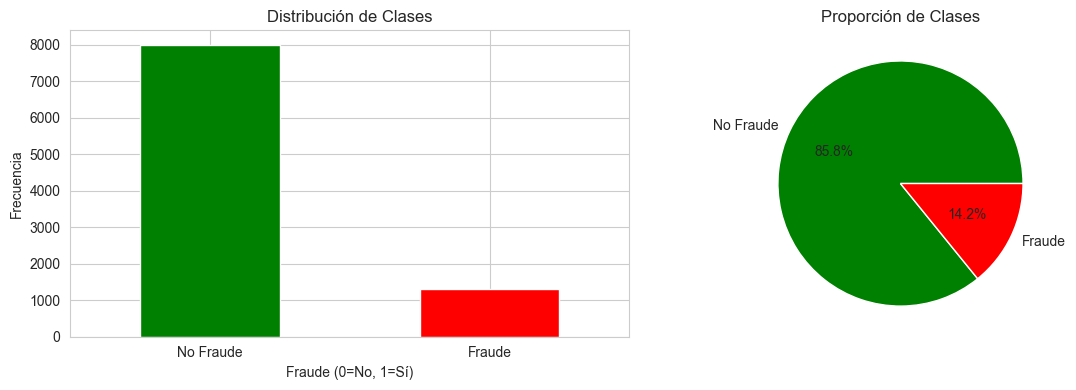


⚠️ Dataset DESBALANCEADO: 85.8% No Fraude vs 14.2% Fraude


In [43]:
# Análisis de la variable objetivo
print("Distribución de la variable objetivo (fraud_flag):")
print(df['fraud_flag'].value_counts())
print(f"\nProporción:")
print(df['fraud_flag'].value_counts(normalize=True))

# Visualizar distribución de clases
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Conteo
df['fraud_flag'].value_counts().plot(kind='bar', ax=ax[0], color=['green', 'red'])
ax[0].set_title('Distribución de Clases')
ax[0].set_xlabel('Fraude (0=No, 1=Sí)')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xticklabels(['No Fraude', 'Fraude'], rotation=0)

# Proporción
df['fraud_flag'].value_counts(normalize=True).plot(kind='pie', ax=ax[1], 
                                                    autopct='%1.1f%%',
                                                    colors=['green', 'red'],
                                                    labels=['No Fraude', 'Fraude'])
ax[1].set_title('Proporción de Clases')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Dataset DESBALANCEADO: {df['fraud_flag'].value_counts(normalize=True)[0]*100:.1f}% No Fraude vs {df['fraud_flag'].value_counts(normalize=True)[1]*100:.1f}% Fraude")

In [44]:
# Identificar las columnas de características agregadas
caracteristicas_agregadas = ['Nb_of_items', 'total_of_items', 'costo_total', 
                              'costo_medio_item', 'costo_item_max', 'costo_item_min']

print("Características agregadas:")
df[caracteristicas_agregadas].describe()

Características agregadas:


,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min
count,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000
mean,1.774761,1.856852,1337.801052,898.376189,1184.433416,647.735165
std,1.541868,1.922323,1070.597321,734.425487,786.942018,841.194373
min,1.000000,1.000000,219.000000,41.615385,130.000000,0.000000
25%,1.000000,1.000000,838.000000,445.500000,749.000000,7.000000
50%,1.000000,1.000000,1124.000000,745.400000,1049.000000,379.000000
75%,2.000000,2.000000,1612.000000,1150.000000,1415.500000,1099.000000
max,38.000000,44.000000,24551.000000,19999.000000,19999.000000,19999.000000


In [45]:
# Identificar columnas de productos (todas excepto ID, características agregadas y fraud_flag)
columnas_productos = [col for col in df.columns 
                      if col not in ['ID'] + caracteristicas_agregadas + ['fraud_flag']]

print(f"Total de columnas de productos: {len(columnas_productos)}")
print(f"\nPrimeros 10 productos:")
print(columnas_productos[:10])

Total de columnas de productos: 2449

Primeros 10 productos:
['APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90', 'AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE', 'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND', 'AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD', 'AUDIO ACCESSORIES | APPLE | AIRPODS PRO', 'AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX', 'AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX NOISE CANCELLING WIRELESS BLUETO']


In [46]:
# Analizar sparsity de los datos de productos
productos_df = df[columnas_productos]
total_valores = productos_df.size
valores_cero = (productos_df == 0).sum().sum()
sparsity = (valores_cero / total_valores) * 100

print(f"Análisis de Dispersión (Sparsity):")
print(f"Total de valores: {total_valores:,}")
print(f"Valores en cero: {valores_cero:,}")
print(f"Sparsity: {sparsity:.2f}%")
print(f"\n💡 Los datos son muy dispersos (sparse)")

Análisis de Dispersión (Sparsity):
Total de valores: 22,822,231
Valores en cero: 22,806,759
Sparsity: 99.93%

💡 Los datos son muy dispersos (sparse)


# 3. División Train/Test (TEMPRANA - Prevenir Data Leakage)

In [47]:
# Separar características (X) y etiqueta (y)
X = df.drop(['ID', 'fraud_flag'], axis=1)
y = df['fraud_flag']

# División estratificada para mantener proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    shuffle=True,
    stratify=y,
    random_state=42
)

print(f"Conjunto de Entrenamiento:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Proporción de fraude: {y_train.mean():.3f}")

print(f"\nConjunto de Prueba:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")
print(f"  Proporción de fraude: {y_test.mean():.3f}")

Conjunto de Entrenamiento:
  X_train: (7455, 2455)
  y_train: (7455,)
  Proporción de fraude: 0.142

Conjunto de Prueba:
  X_test: (1864, 2455)
  y_test: (1864,)
  Proporción de fraude: 0.142


In [48]:
from sklearn.preprocessing import StandardScaler

# NORMALIZACIÓN DE DATOS (previene overflow numérico)
# IMPORTANTE: Ajustar scaler SOLO en training data para prevenir data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Datos normalizados con StandardScaler")
print(f"Forma X_train_scaled: {X_train_scaled.shape}")
print(f"Forma X_test_scaled: {X_test_scaled.shape}")
print(f"\nEstadísticas después del escalado (Training):")
print(f"  Media: {X_train_scaled.mean():.10f} (debe ser ≈0)")
print(f"  Desviación estándar: {X_train_scaled.std():.10f} (debe ser ≈1)")
print(f"  Min: {X_train_scaled.min():.4f}")
print(f"  Max: {X_train_scaled.max():.4f}")
print(f"\n💡 La normalización previene overflow en productos con precios muy diferentes")

✅ Datos normalizados con StandardScaler
Forma X_train_scaled: (7455, 2455)
Forma X_test_scaled: (1864, 2455)

Estadísticas después del escalado (Training):
  Media: 0.0000000000 (debe ser ≈0)
  Desviación estándar: 0.9338617455 (debe ser ≈1)
  Min: -1.3951
  Max: 86.3366

💡 La normalización previene overflow en productos con precios muy diferentes


# 4. Exploración de Datos en Conjunto de Entrenamiento

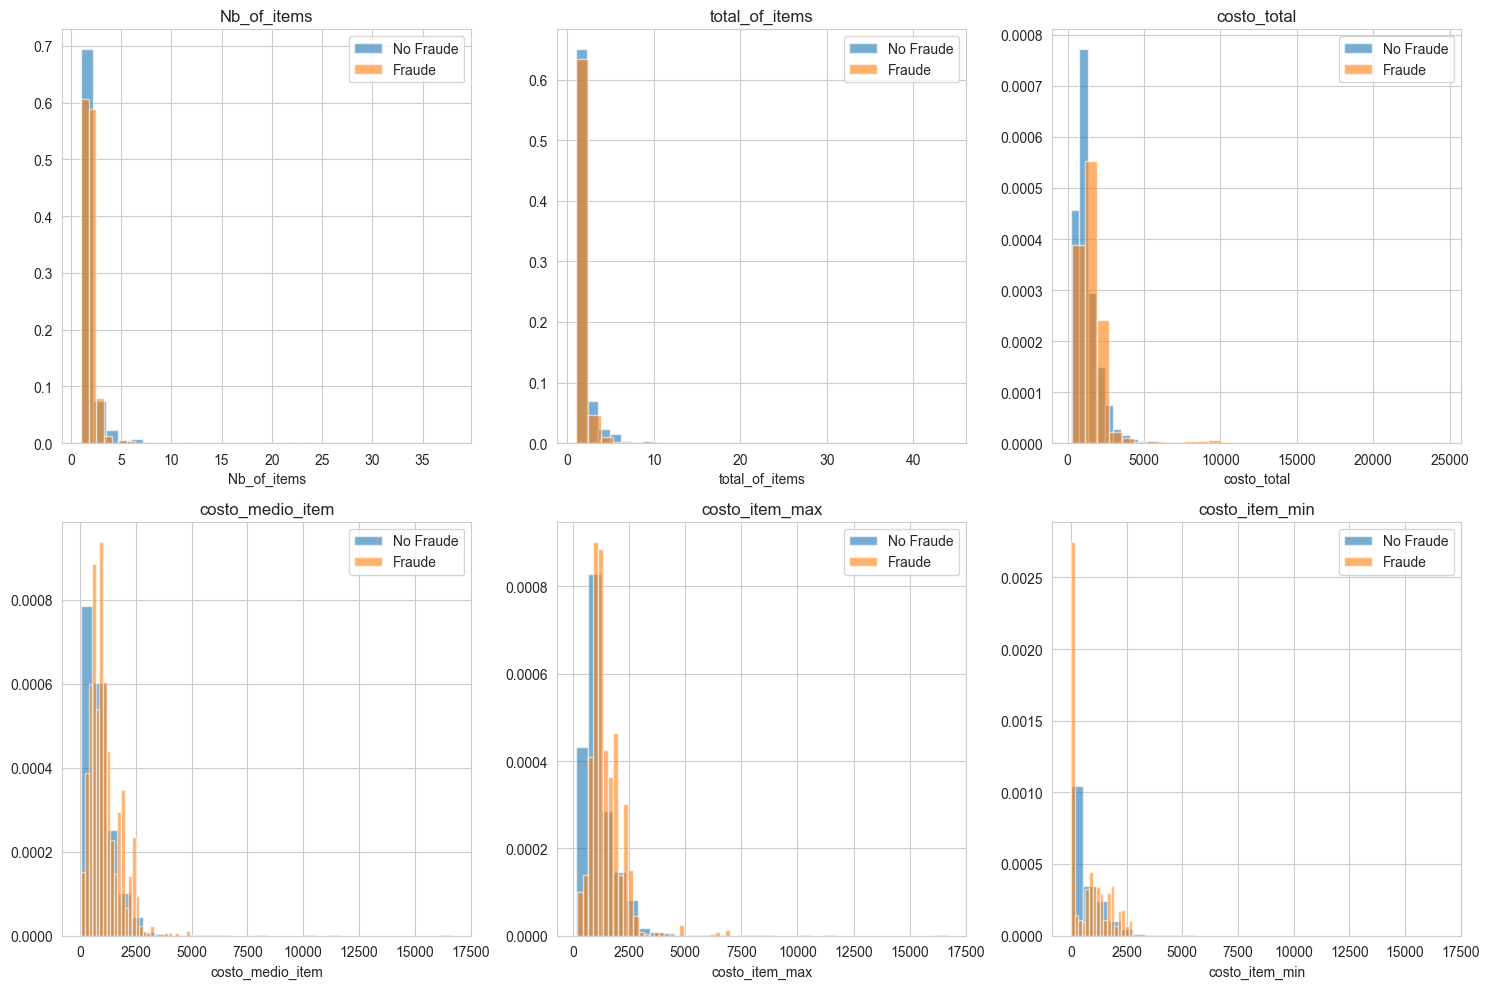

In [49]:
# Crear DataFrame temporal con train data para exploración
df_train = pd.concat([X_train, y_train], axis=1)

# Análisis univariado de características agregadas por clase
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(caracteristicas_agregadas):
    df_train.groupby('fraud_flag')[col].hist(alpha=0.6, bins=30, ax=axes[i], density=True)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].legend(['No Fraude', 'Fraude'])

plt.tight_layout()
plt.show()

In [50]:
# Estadísticas descriptivas por clase
print("Estadísticas de características agregadas por clase:\n")
print("NO FRAUDE (0):")
print(df_train[df_train['fraud_flag']==0][caracteristicas_agregadas].describe())
print("\n" + "="*80 + "\n")
print("FRAUDE (1):")
print(df_train[df_train['fraud_flag']==1][caracteristicas_agregadas].describe())

Estadísticas de características agregadas por clase:

NO FRAUDE (0):
       Nb_of_items  total_of_items   costo_total  costo_medio_item  \
count  6400.000000     6400.000000   6400.000000       6400.000000   
mean      1.792812        1.876562   1291.569688        861.831525   
std       1.612251        1.899675   1002.804170        696.781881   
min       1.000000        1.000000    219.000000         41.615385   
25%       1.000000        1.000000    768.000000        409.000000   
50%       1.000000        1.000000   1099.000000        693.000000   
75%       2.000000        2.000000   1510.500000       1117.000000   
max      38.000000       40.000000  16699.000000      16699.000000   

       costo_item_max  costo_item_min  
count     6400.000000     6400.000000  
mean      1137.666250      625.695156  
std        744.094624      802.519238  
min        130.000000        0.000000  
25%        699.000000       11.000000  
50%        999.000000      379.000000  
75%       1363.00000

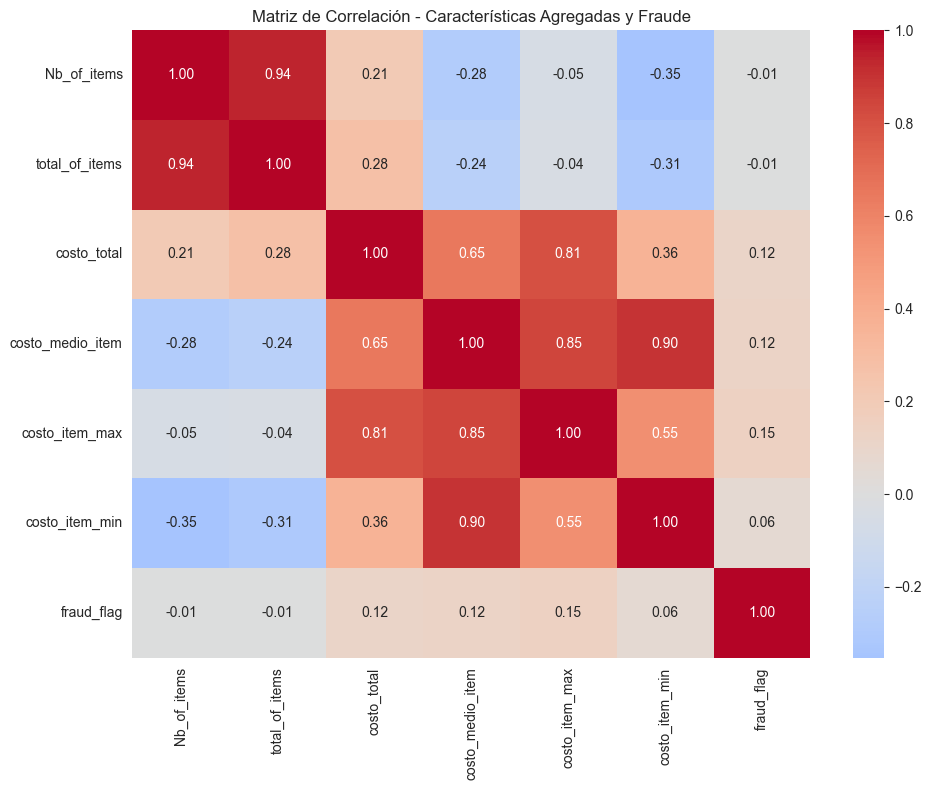


Correlación con fraud_flag:
fraud_flag          1.000000
costo_item_max      0.145403
costo_medio_item    0.121308
costo_total         0.115606
costo_item_min      0.060075
total_of_items     -0.006650
Nb_of_items        -0.007038
Name: fraud_flag, dtype: float64


In [51]:
# Matriz de correlación de características agregadas
plt.figure(figsize=(10, 8))
correlacion = df_train[caracteristicas_agregadas + ['fraud_flag']].corr()
sns.heatmap(correlacion, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matriz de Correlación - Características Agregadas y Fraude')
plt.tight_layout()
plt.show()

print("\nCorrelación con fraud_flag:")
print(correlacion['fraud_flag'].sort_values(ascending=False))

In [52]:
# Productos más frecuentes en fraude vs no-fraude
productos_fraude = df_train[df_train['fraud_flag']==1][columnas_productos]
productos_no_fraude = df_train[df_train['fraud_flag']==0][columnas_productos]

# Top 10 productos en canastas fraudulentas
top_fraude = (productos_fraude > 0).sum().sort_values(ascending=False).head(10)
print("Top 10 productos más frecuentes en FRAUDE:")
print(top_fraude)

print("\n" + "="*80 + "\n")

# Top 10 productos en canastas no fraudulentas
top_no_fraude = (productos_no_fraude > 0).sum().sort_values(ascending=False).head(10)
print("Top 10 productos más frecuentes en NO FRAUDE:")
print(top_no_fraude)

Top 10 productos más frecuentes en FRAUDE:
FULFILMENT CHARGE | RETAILER | RETAILER                                        404
COMPUTERS | APPLE | 2020 APPLE MACBOOK PRO 13 TOUCH BAR M1 PROCESSOR 8         133
COMPUTERS | APPLE | 2021 APPLE MACBOOK PRO 14 M1 PRO PROCESSOR 16GB RA         124
COMPUTERS | APPLE | 2020 APPLE MACBOOK AIR 13 3 RETINA DISPLAY M1 PROC         119
COMPUTERS | APPLE | 2021 APPLE IPAD PRO 11 M1 PROCESSOR IOS WI-FI 128G          63
COMPUTERS | APPLE | 2021 APPLE MACBOOK PRO 16 M1 PRO PROCESSOR 16GB RA          62
COMPUTERS | APPLE | 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-FI CE          55
COMPUTERS | APPLE | 2020 APPLE MACBOOK PRO 13 TOUCH BAR INTEL CORE I5           43
COMPUTERS | APPLE | 2021 APPLE IPAD PRO 12 9 M1 PROCESSOR IOS WI-FI 25          34
TELEPHONES, FAX MACHINES & TWO-WAY RADIOS | APPLE | APPLE IPHONE 12 PRO MAX     32
dtype: int64


Top 10 productos más frecuentes en NO FRAUDE:
FULFILMENT CHARGE | RETAILER | RETAILER                           

# 5. Modelo 1: Regresión Logística con Regularización Lasso

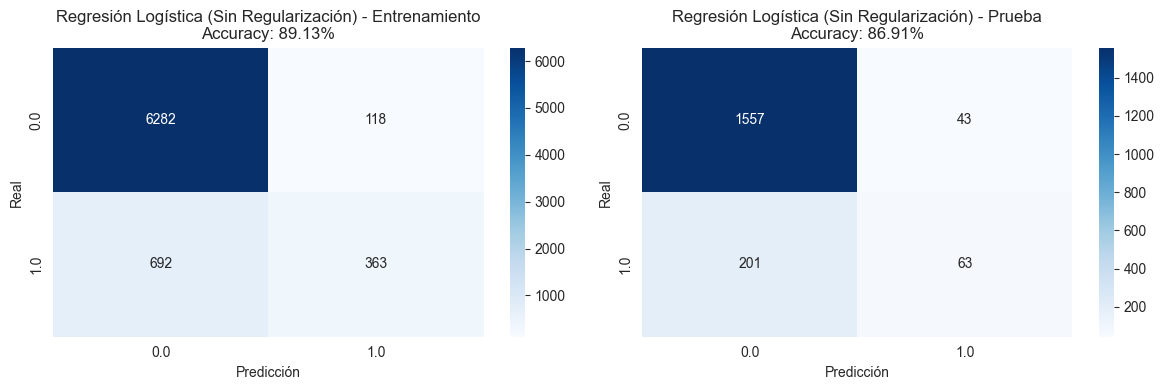


Reporte de Clasificación - Regresión Logística (Sin Regularización) (Conjunto de Prueba)
              precision    recall  f1-score   support

   No Fraude       0.89      0.97      0.93      1600
      Fraude       0.59      0.24      0.34       264

    accuracy                           0.87      1864
   macro avg       0.74      0.61      0.63      1864
weighted avg       0.84      0.87      0.84      1864



In [54]:
# Entrenar modelo base con datos ESCALADOS
modelo_base = LogisticRegression(
    penalty=None,
    max_iter=1000,
    random_state=42,
    solver='sag'
).fit(X_train_scaled, y_train)

# Evaluar
acc_train_base, acc_test_base = evaluacion_modelo(
    modelo_base, X_train_scaled, y_train, X_test_scaled, y_test, 
    nombre_modelo='Regresión Logística (Sin Regularización)'
)

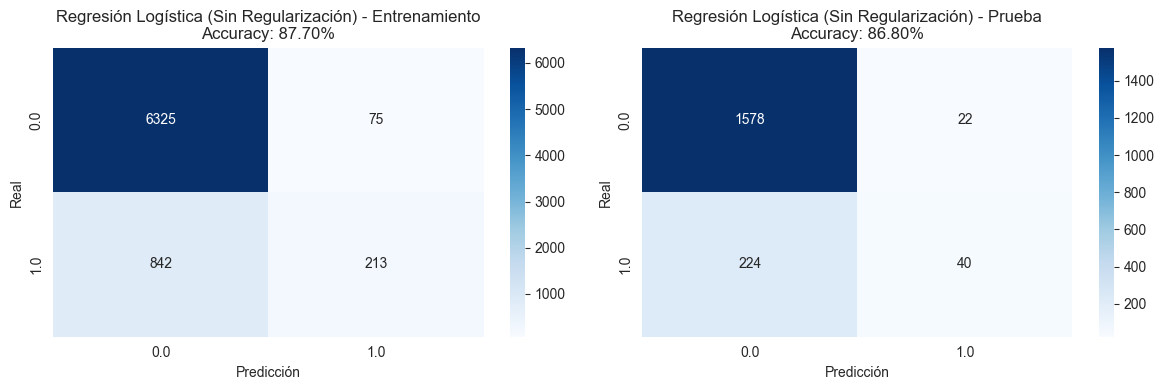


Reporte de Clasificación - Regresión Logística (Sin Regularización) (Conjunto de Prueba)
              precision    recall  f1-score   support

   No Fraude       0.88      0.99      0.93      1600
      Fraude       0.65      0.15      0.25       264

    accuracy                           0.87      1864
   macro avg       0.76      0.57      0.59      1864
weighted avg       0.84      0.87      0.83      1864



In [53]:
# Entrenar modelo base
modelo_base = LogisticRegression(
    penalty=None,
    max_iter=1000,
    random_state=42,
    solver='saga'
).fit(X_train, y_train)

# Evaluar
acc_train_base, acc_test_base = evaluacion_modelo(
    modelo_base, X_train, y_train, X_test, y_test, 
    nombre_modelo='Regresión Logística (Sin Regularización)'
)

In [55]:
%%time

# Valores de lambda y C (C = 1/lambda)
# Rango reducido inicialmente para verificar convergencia sin overflow
lambdas = np.array([0.01, 0.1, 1, 10, 100])
C_values = 1 / lambdas

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search con Lasso (L1)
# Nota: Lasso es mejor para datos dispersos (sparse) y hace selección automática de características
modelo_lasso = LogisticRegression(
    penalty='l1',          # L1 (Lasso)
    max_iter=50000,        # Aumentado para convergencia
    solver='saga',         # Compatible con L1 y datos dispersos
    tol=1e-4,              # Tolerancia para convergencia
    warm_start=True,
    random_state=42,
    verbose=0
)

# Temporalmente habilitar warnings para ver si hay problemas de convergencia
warnings.filterwarnings('default')

grid_search = GridSearchCV(
    estimator=modelo_lasso,
    param_grid={'C': C_values},
    cv=kf,
    return_train_score=True,
    verbose=2,
    n_jobs=-1,              # Usar todos los núcleos del CPU
    pre_dispatch='2*n_jobs' # Controlar memoria
).fit(X_train_scaled, y_train)  # ← USAR DATOS ESCALADOS

# Volver a deshabilitar warnings
warnings.filterwarnings('ignore')

print(f"\n{'='*60}")
print(f"Mejor parámetro C: {grid_search.best_params_['C']}")
print(f"Mejor score (CV): {grid_search.best_score_:.4f}")
print(f"{'='*60}")

# Verificar si hubo problemas numéricos
if np.isnan(grid_search.best_score_):
    print("⚠️ ERROR: Resultados inválidos (NaN) - revisar overflow")
else:
    print("✅ Entrenamiento exitoso sin overflow")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END .............................................C=10.0; total time= 8.3min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ............................................C=100.0; total time= 8.6min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ..............................................C=1.0; total time= 9.8min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ..............................................C=1.0; total time=11.3min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ............................................C=100.0; total time=12.7min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END .............................................C=10.0; total time=12.8min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ............................................C=100.0; total time=13.5min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END .............................................C=10.0; total time=13.6min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ............................................C=100.0; total time=14.0min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ..............................................C=0.1; total time= 2.9min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END .............................................C=10.0; total time=14.9min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ............................................C=100.0; total time=15.0min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END .............................................C=0.01; total time= 1.2min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END .............................................C=0.01; total time= 1.2min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END .............................................C=10.0; total time=15.5min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ..............................................C=0.1; total time= 2.8min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ..............................................C=0.1; total time= 2.9min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ..............................................C=1.0; total time= 7.2min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END .............................................C=0.01; total time=  58.4s


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END .............................................C=0.01; total time= 1.1min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END .............................................C=0.01; total time=  56.4s


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ..............................................C=0.1; total time= 2.7min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ..............................................C=0.1; total time= 2.8min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ..............................................C=1.0; total time= 8.6min


/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/andrestrevino/Bourbaki/Working_Analyst/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

[CV] END ..............................................C=1.0; total time=11.8min

Mejor parámetro C: 0.1
Mejor score (CV): 0.8720
✅ Entrenamiento exitoso sin overflow
CPU times: user 2min 47s, sys: 1.57 s, total: 2min 48s
Wall time: 22min 49s


Resultados de Grid Search:
   param_C  mean_train_score  mean_test_score
0   100.00          0.891616         0.803219
1    10.00          0.891616         0.826425
2     1.00          0.890845         0.871630
3     0.10          0.887290         0.872032
4     0.01          0.862307         0.861301


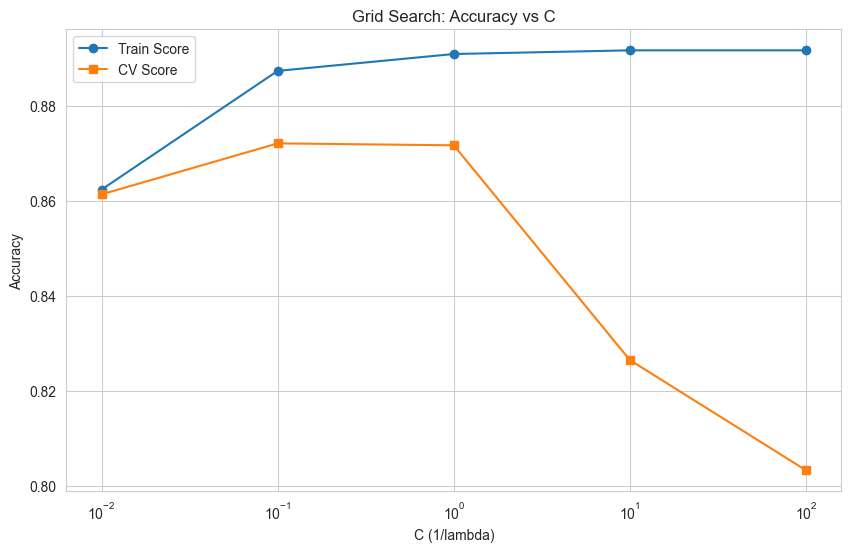

In [56]:
# Resultados del Grid Search
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_display = cv_results[['param_C', 'mean_train_score', 'mean_test_score']]
print("Resultados de Grid Search:")
print(cv_results_display)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(cv_results['param_C'], cv_results['mean_train_score'], marker='o', label='Train Score')
plt.plot(cv_results['param_C'], cv_results['mean_test_score'], marker='s', label='CV Score')
plt.xscale('log')
plt.xlabel('C (1/lambda)')
plt.ylabel('Accuracy')
plt.title('Grid Search: Accuracy vs C')
plt.legend()
plt.grid(True)
plt.show()

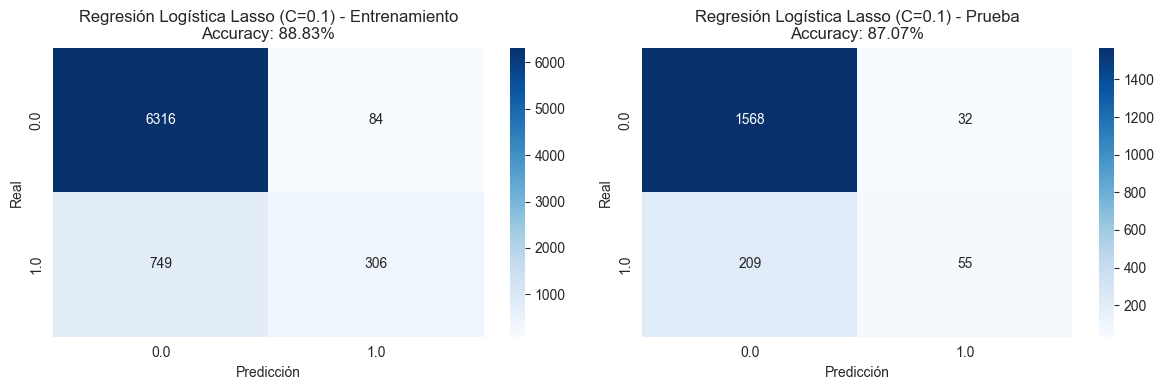


Reporte de Clasificación - Regresión Logística Lasso (C=0.1) (Conjunto de Prueba)
              precision    recall  f1-score   support

   No Fraude       0.88      0.98      0.93      1600
      Fraude       0.63      0.21      0.31       264

    accuracy                           0.87      1864
   macro avg       0.76      0.59      0.62      1864
weighted avg       0.85      0.87      0.84      1864


Características seleccionadas por Lasso: 340 de 2455
Porcentaje: 13.85%


In [57]:
# Mejor C
best_C = grid_search.best_params_['C']

# Entrenar modelo final con Lasso usando datos ESCALADOS
modelo_lasso_final = LogisticRegression(
    penalty='l1',
    C=best_C,
    max_iter=10000,
    solver='saga',
    random_state=42
).fit(X_train_scaled, y_train)

# Evaluar
acc_train_lasso, acc_test_lasso = evaluacion_modelo(
    modelo_lasso_final, X_train_scaled, y_train, X_test_scaled, y_test,
    nombre_modelo=f'Regresión Logística Lasso (C={best_C})'
)

# Contar cuántas características fueron seleccionadas (coeficientes no cero)
n_features_selected = np.sum(modelo_lasso_final.coef_ != 0)
print(f"\n{'='*60}")
print(f"Características seleccionadas por Lasso: {n_features_selected} de {X_train_scaled.shape[1]}")
print(f"Porcentaje: {(n_features_selected/X_train_scaled.shape[1])*100:.2f}%")
print(f"{'='*60}")

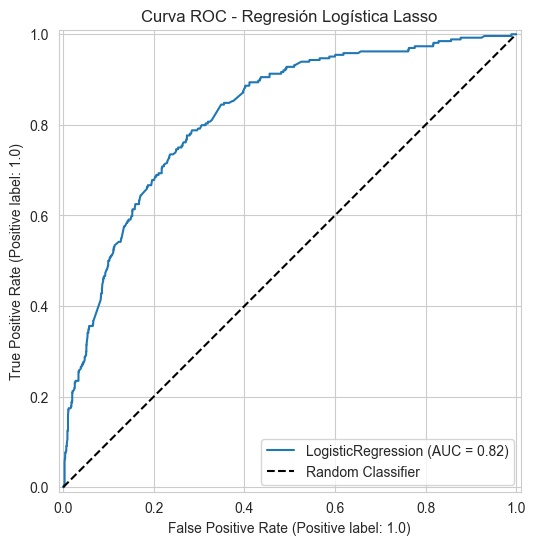

In [58]:
# Curva ROC usando datos ESCALADOS
RocCurveDisplay.from_estimator(modelo_lasso_final, X_test_scaled, y_test)
plt.title('Curva ROC - Regresión Logística Lasso')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.legend()
plt.grid(True)
plt.show()


UMBRAL = 0.1


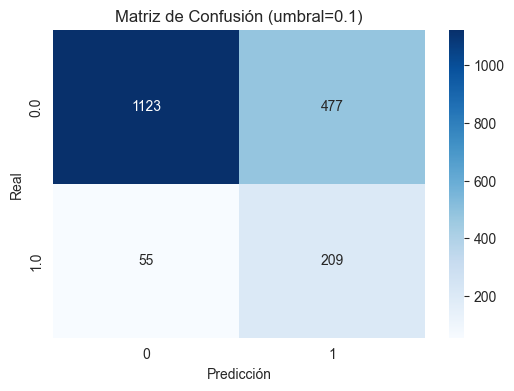


Accuracy con umbral 0.1: 71.46%

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Fraude       0.95      0.70      0.81      1600
      Fraude       0.30      0.79      0.44       264

    accuracy                           0.71      1864
   macro avg       0.63      0.75      0.62      1864
weighted avg       0.86      0.71      0.76      1864



In [ ]:
# Umbral = 0.1 (más sensible al fraude)
print("\n" + "="*60)
print("UMBRAL = 0.1")
print("="*60)
matriz_confusion_con_umbral(modelo_lasso_final, X_test_scaled, y_test, umbral=.1)